In [1]:
# Standard library imports
import os
import warnings
import pickle

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Scikit-learn imports
from sklearn import (
    ensemble, 
    model_selection, 
    preprocessing, 
    impute,
    neighbors,
    metrics,
    pipeline,
    decomposition,
    manifold,
    discriminant_analysis,
    linear_model,
    svm,
    tree,
    exceptions
)
from sklearn.utils.class_weight import compute_class_weight

# XGBoost import
from xgboost import XGBClassifier

# UMAP import
import umap

# Filter warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=exceptions.FitFailedWarning)
warnings.filterwarnings('ignore', category=exceptions.ConvergenceWarning)

# Specific imports for better code completion
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    BaggingClassifier
)
from sklearn.model_selection import (
    train_test_split, 
    KFold, 
    cross_val_score, 
    GridSearchCV
)
from sklearn.preprocessing import (
    StandardScaler, 
    LabelEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    RocCurveDisplay,
    roc_curve,
    auc
)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier



2025-08-23 15:33:32.428857: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-23 15:33:32.488810: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-23 15:33:34.744325: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
csv_files = [k for k in os.listdir() if k.endswith(".csv")]

In [3]:
err_df = []
for k in csv_files:
    try:
        df = pd.read_csv(k, sep = ";",header=None)
        #print(df.columns.__len__())
        if df.columns.__len__() != 301:
            print(f"check cols in {k}")
            err_df.append(k)
    except:
        print(k)
print(f"err df: {err_df}")

analisys_pore_data_10013.csv
analisys_pore_data_28.csv
analisys_pore_data_13.csv
analisys_pore_data_32.csv
err df: []


In [4]:
dfs = []

for k in csv_files:
    try:
        df = pd.read_csv(k, sep = ";", header=None)
        number = k[k.rfind("_") + 1:k.rfind(".")]
        if len(number):
            number = number[-3:]
        df["Rock ID"] = number
        dfs.append(df)
    except:
        print(k)

analisys_pore_data_10013.csv
analisys_pore_data_28.csv
analisys_pore_data_13.csv
analisys_pore_data_32.csv


In [5]:
s = "analisys_pore_data_10013.csv"
print(len(s))
print(s.rfind("_"))
print(s[s.rfind("_") + 1:s.rfind(".")])
n = s[s.rfind("_") + 1:s.rfind(".")]
if len(n):
    print(n[-2:])

28
18
10013
13


In [6]:
data = pd.concat(dfs, ignore_index=True)

In [7]:
data["Rock ID"] = data["Rock ID"].astype(int).astype(str)

In [8]:
data = data.drop(columns=[300])
data.shape

(40045, 301)

In [9]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.to_list()

In [10]:
ren_dict = {}
for k in numeric_cols:
    ren_dict[k] = str(k)

In [11]:
data=data.rename(ren_dict)

In [12]:
data[numeric_cols] = data[numeric_cols].replace([np.inf, -np.inf], np.nan)

In [13]:
imputer = SimpleImputer(strategy="mean")
data[numeric_cols] = imputer.fit_transform(data[numeric_cols])

In [14]:
columns_to_drop = []
for col in data.columns:
    if pd.api.types.is_numeric_dtype(data[col]):
        zero_ratio = (data[col] == 0).mean()
        if zero_ratio > 0.5:
            columns_to_drop.append(col)
            
columns_to_drop.__len__()

164

In [15]:
with open("columns_to_drop.pkl", "wb") as file:
    pickle.dump(columns_to_drop, file)

In [16]:
data

0            1          2         3             4         5  \
0      284005.0   538.477631  -6.366198  0.002396   6789.983871  2.773499   
1      285013.0   535.163923  -8.276057  0.002391  21744.720351  2.786968   
2      286073.0   534.335495  -5.729578  0.005928   9472.677022  1.748717   
3      286971.0   530.089806  -6.047888  0.002465  23861.585331  2.887474   
4      287945.0   535.681690  -3.819719  0.002746   1805.876419  2.650908   
...         ...          ...        ...       ...           ...       ...   
40040  471169.0  1750.052301 -58.887329  0.055171   9373.463417  1.241836   
40041  470120.0  1745.288845 -55.067610  0.055329  12432.640022  1.346880   
40042  468736.0  1753.987330 -49.019722  0.041334   5214.935626  1.210223   
40043  467335.0  1729.859390 -53.157751  0.041299   4875.128403  1.234066   
40044  466231.0  1716.397449 -54.430991  0.041265   4500.540838  1.211264   

                6            7            8            9  ...  291  292  293  \
0      215.712633  1985.901760   108.876833   108.876833  ...  0.0  0.0  0.0   
1      227.744263  2756.241581   105.980966   105.980966  ...  0.0  0.0  0.0   
2      290.272611  1353.426143   420.658851   420.658851  ...  0.0  0.0  0.0   
3      136.590439  2796.062059    88.354020    88.354020  ...  0.0  0.0  0.0   
4      150.418867   638.892812    91.206810    91.206810  ...  0.0  0.0  0.0   
...           ...          ...          ...          ...  ...  ...  ...  ...   
40040  860.618601  6257.916839  4258.841021  4258.841021  ...  0.0  0.0  0.0   
40041  740.716759  7013.201090  3650.112766  3650.112766  ...  0.0  0.0  0.0   
40042  571.059569  3314.052647  2114.644334  2114.644334  ...  0.0  0.0  0.0   
40043  522.785865  3116.637840  2088.720048  2088.720048  ...  0.0  0.0  0.0   
40044  536.187256  2873.930682  1993.151393  1993.151393  ...  0.0  0.0  0.0   

       294  295  296  297  298  299  Rock ID  
0      0.0  0.0  0.0  0.0  0.0  0.0       52  
1      0.0  0.0  0.0  0.0  0.0  0.0       52  
2      0.0  0.0  0.0  0.0  0.0  0.0       52  
3      0.0  0.0  0.0  0.0  0.0  0.0       52  
4      0.0  0.0  0.0  0.0  0.0  0.0       52  
...    ...  ...  ...  ...  ...  ...      ...  
40040  0.0  0.0  0.0  0.0  0.0  0.0        9  
40041  0.0  0.0  0.0  0.0  0.0  0.0        9  
40042  0.0  0.0  0.0  0.0  0.0  0.0        9  
40043  0.0  0.0  0.0  0.0  0.0  0.0        9  
40044  0.0  0.0  0.0  0.0  0.0  0.0        9  

[40045 rows x 301 columns]

In [17]:
data.drop(columns=columns_to_drop, inplace=True)

In [18]:
data

0            1          2         3             4         5  \
0      284005.0   538.477631  -6.366198  0.002396   6789.983871  2.773499   
1      285013.0   535.163923  -8.276057  0.002391  21744.720351  2.786968   
2      286073.0   534.335495  -5.729578  0.005928   9472.677022  1.748717   
3      286971.0   530.089806  -6.047888  0.002465  23861.585331  2.887474   
4      287945.0   535.681690  -3.819719  0.002746   1805.876419  2.650908   
...         ...          ...        ...       ...           ...       ...   
40040  471169.0  1750.052301 -58.887329  0.055171   9373.463417  1.241836   
40041  470120.0  1745.288845 -55.067610  0.055329  12432.640022  1.346880   
40042  468736.0  1753.987330 -49.019722  0.041334   5214.935626  1.210223   
40043  467335.0  1729.859390 -53.157751  0.041299   4875.128403  1.234066   
40044  466231.0  1716.397449 -54.430991  0.041265   4500.540838  1.211264   

                6            7            8            9  ...     156     157  \
0      215.712633  1985.901760   108.876833   108.876833  ...  7424.0  6440.0   
1      227.744263  2756.241581   105.980966   105.980966  ...  7401.0  6343.0   
2      290.272611  1353.426143   420.658851   420.658851  ...  7658.0  6293.0   
3      136.590439  2796.062059    88.354020    88.354020  ...  7601.0  6365.0   
4      150.418867   638.892812    91.206810    91.206810  ...  7512.0  6537.0   
...           ...          ...          ...          ...  ...     ...     ...   
40040  860.618601  6257.916839  4258.841021  4258.841021  ...  2793.0  2615.0   
40041  740.716759  7013.201090  3650.112766  3650.112766  ...  2857.0  2517.0   
40042  571.059569  3314.052647  2114.644334  2114.644334  ...  2845.0  2645.0   
40043  522.785865  3116.637840  2088.720048  2088.720048  ...  2958.0  2581.0   
40044  536.187256  2873.930682  1993.151393  1993.151393  ...  2856.0  2678.0   

          158     161     163     165    167    172   176  Rock ID  
0      5220.0  2867.0  1691.0   981.0  507.0   80.0   8.0       52  
1      5290.0  2904.0  1655.0  1010.0  576.0   76.0  12.0       52  
2      5192.0  2714.0  1722.0  1020.0  580.0   70.0  10.0       52  
3      5243.0  2776.0  1709.0   962.0  527.0   78.0  20.0       52  
4      5428.0  2832.0  1754.0   956.0  563.0   80.0  18.0       52  
...       ...     ...     ...     ...    ...    ...   ...      ...  
40040  2396.0  1783.0  1455.0  1042.0  766.0  247.0  92.0        9  
40041  2421.0  1820.0  1458.0  1102.0  779.0  280.0  83.0        9  
40042  2429.0  1779.0  1444.0  1101.0  791.0  255.0  79.0        9  
40043  2379.0  1842.0  1394.0  1058.0  720.0  280.0  76.0        9  
40044  2398.0  1964.0  1428.0  1035.0  755.0  272.0  83.0        9  

[40045 rows x 137 columns]

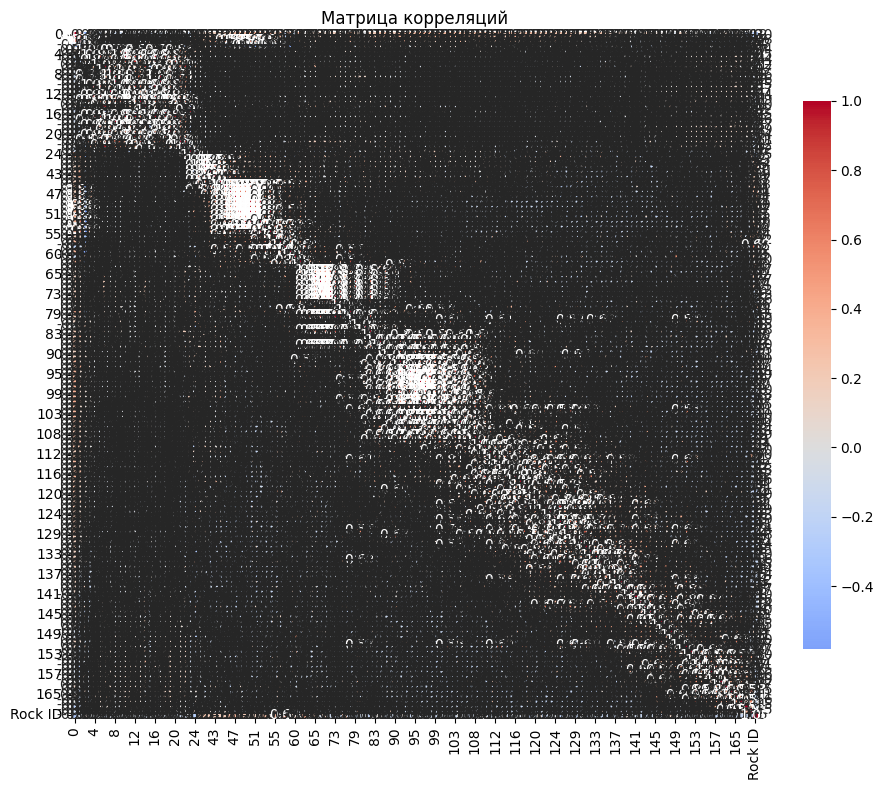

In [19]:
correlation_matrix = data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    center = 0,
    square=True,
    fmt = '.2f',
    cbar_kws={"shrink": 0.8}
)

plt.title("Матрица корреляций")
plt.tight_layout()
plt.show()

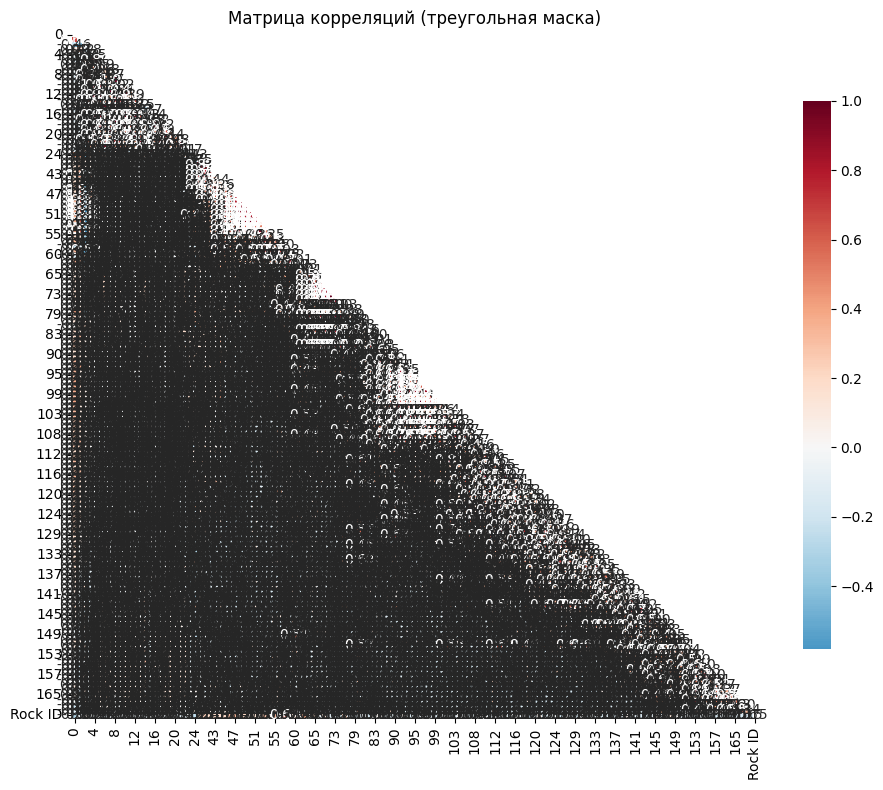

In [20]:
# Улучшенная визуализация с маской для верхней треугольной матрицы
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    mask=mask,         # Скрываем верхний треугольник
    annot=True, 
    cmap='RdBu_r',     # Другая цветовая схема
    center=0,
    square=True,
    fmt=".2f",
    cbar_kws={"shrink": 0.8}
)
plt.title('Матрица корреляций (треугольная маска)')
plt.tight_layout()
plt.show()

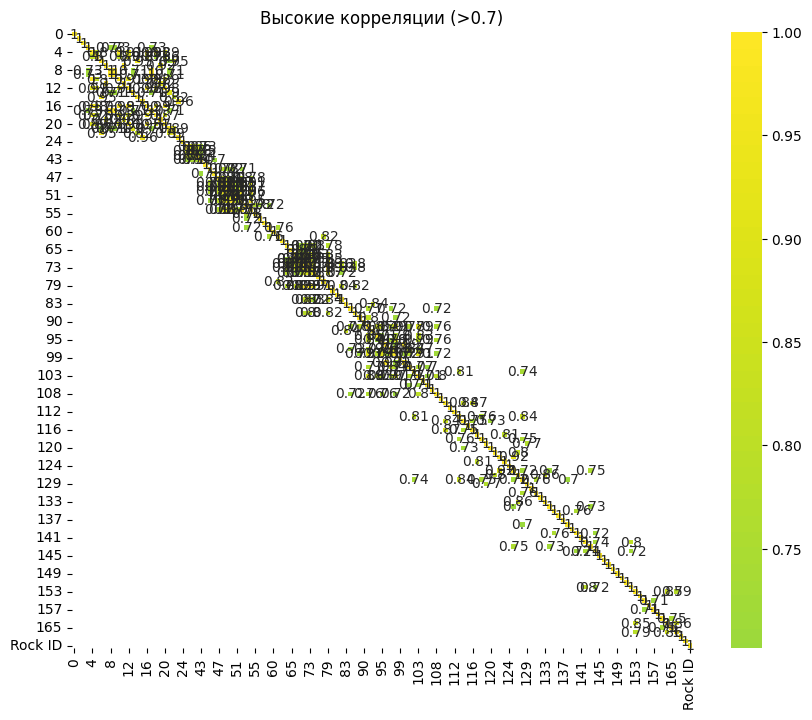

In [21]:
# Фильтрация высоких корреляций
high_corr = correlation_matrix[abs(correlation_matrix) > 0.7]
plt.figure(figsize=(10, 8))
sns.heatmap(high_corr, annot=True, cmap='viridis', center=0)
plt.title('Высокие корреляции (>0.7)')
plt.show()

In [22]:
# Пример подхода к удалению коррелированных признаков
def optimize_correlation_removal(df, target_column=None, threshold=0.85):
    """
    Умное удаление коррелированных признаков с учетом важности для целевой переменной
    """
    # Вычисляем матрицу корреляций
    corr_matrix = df.corr().abs()
    
    # Верхний треугольник матрицы
    upper = corr_matrix.where(np.triu(np.ones_like(corr_matrix, dtype=bool), k=1))
    
    # Находим высококоррелированные пары
    high_corr_pairs = []
    for column in upper.columns:
        high_corr = upper[column][upper[column] > threshold]
        if not high_corr.empty:
            for corr_column, corr_value in high_corr.items():
                high_corr_pairs.append((column, corr_column, corr_value))
    
    # Если есть целевая переменная, оцениваем важность признаков
    if target_column and target_column in df.columns:
        target_correlations = df.corr()[target_column].abs().drop(target_column)
    
    # Выбираем какие признаки удалить
    to_drop = set()
    for col1, col2, corr_value in high_corr_pairs:
        # Выбираем какой признак удалить
        if target_column and target_column in df.columns:
            # Сохраняем признак с большей корреляцией с целевой переменной
            if target_correlations[col1] > target_correlations[col2]:
                to_drop.add(col2)
            else:
                to_drop.add(col1)
        else:
            # Сохраняем признак с большей дисперсией
            if df[col1].var() > df[col2].var():
                to_drop.add(col2)
            else:
                to_drop.add(col1)
    
    # Удаляем выбранные признаки
    df_reduced = df.drop(columns=to_drop)
    
    print(f"Удалено {len(to_drop)} коррелированных признаков")
    return df_reduced



In [23]:
data_ = data["Rock ID"]
data =data.drop(columns="Rock ID")

In [24]:
data

0            1          2         3             4         5    \
0      284005.0   538.477631  -6.366198  0.002396   6789.983871  2.773499   
1      285013.0   535.163923  -8.276057  0.002391  21744.720351  2.786968   
2      286073.0   534.335495  -5.729578  0.005928   9472.677022  1.748717   
3      286971.0   530.089806  -6.047888  0.002465  23861.585331  2.887474   
4      287945.0   535.681690  -3.819719  0.002746   1805.876419  2.650908   
...         ...          ...        ...       ...           ...       ...   
40040  471169.0  1750.052301 -58.887329  0.055171   9373.463417  1.241836   
40041  470120.0  1745.288845 -55.067610  0.055329  12432.640022  1.346880   
40042  468736.0  1753.987330 -49.019722  0.041334   5214.935626  1.210223   
40043  467335.0  1729.859390 -53.157751  0.041299   4875.128403  1.234066   
40044  466231.0  1716.397449 -54.430991  0.041265   4500.540838  1.211264   

              6            7            8            9    ...     155     156  \
0      215.712633  1985.901760   108.876833   108.876833  ...  8656.0  7424.0   
1      227.744263  2756.241581   105.980966   105.980966  ...  8591.0  7401.0   
2      290.272611  1353.426143   420.658851   420.658851  ...  8633.0  7658.0   
3      136.590439  2796.062059    88.354020    88.354020  ...  8690.0  7601.0   
4      150.418867   638.892812    91.206810    91.206810  ...  8862.0  7512.0   
...           ...          ...          ...          ...  ...     ...     ...   
40040  860.618601  6257.916839  4258.841021  4258.841021  ...  3005.0  2793.0   
40041  740.716759  7013.201090  3650.112766  3650.112766  ...  2980.0  2857.0   
40042  571.059569  3314.052647  2114.644334  2114.644334  ...  3093.0  2845.0   
40043  522.785865  3116.637840  2088.720048  2088.720048  ...  3139.0  2958.0   
40044  536.187256  2873.930682  1993.151393  1993.151393  ...  3123.0  2856.0   

          157     158     161     163     165    167    172   176  
0      6440.0  5220.0  2867.0  1691.0   981.0  507.0   80.0   8.0  
1      6343.0  5290.0  2904.0  1655.0  1010.0  576.0   76.0  12.0  
2      6293.0  5192.0  2714.0  1722.0  1020.0  580.0   70.0  10.0  
3      6365.0  5243.0  2776.0  1709.0   962.0  527.0   78.0  20.0  
4      6537.0  5428.0  2832.0  1754.0   956.0  563.0   80.0  18.0  
...       ...     ...     ...     ...     ...    ...    ...   ...  
40040  2615.0  2396.0  1783.0  1455.0  1042.0  766.0  247.0  92.0  
40041  2517.0  2421.0  1820.0  1458.0  1102.0  779.0  280.0  83.0  
40042  2645.0  2429.0  1779.0  1444.0  1101.0  791.0  255.0  79.0  
40043  2581.0  2379.0  1842.0  1394.0  1058.0  720.0  280.0  76.0  
40044  2678.0  2398.0  1964.0  1428.0  1035.0  755.0  272.0  83.0  

[40045 rows x 136 columns]

In [25]:
# Использование
df_optimized = optimize_correlation_removal(data, target_column='target', threshold=0.85)

Удалено 33 коррелированных признаков


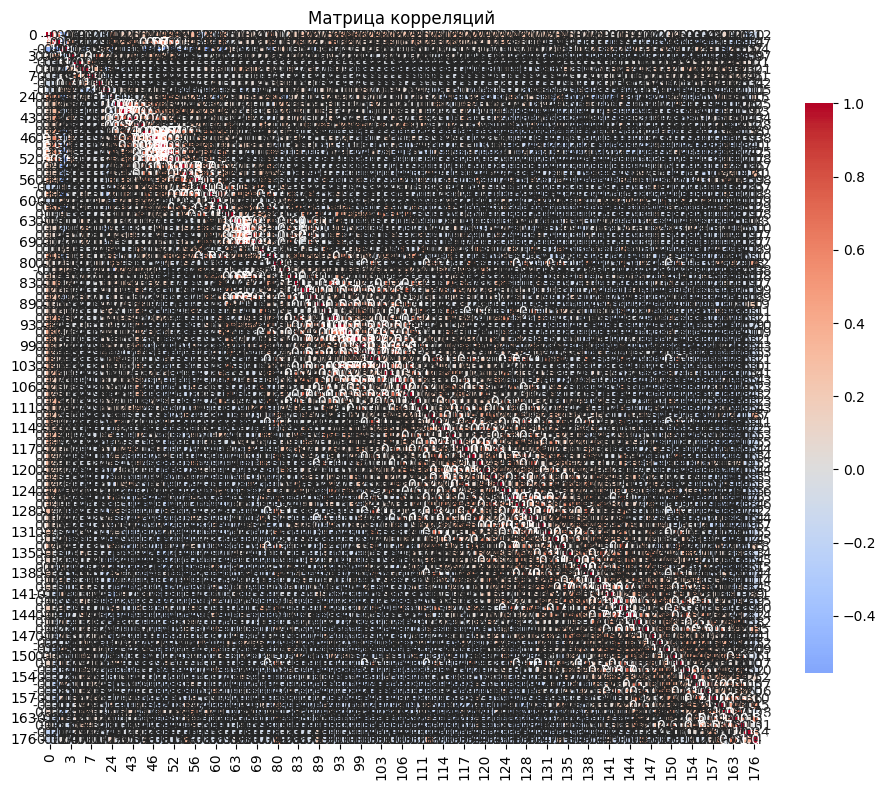

In [26]:
correlation_matrix = df_optimized.corr()
plt.figure(figsize=(10,8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    center = 0,
    square=True,
    fmt = '.2f',
    cbar_kws={"shrink": 0.8}
)

plt.title("Матрица корреляций")
plt.tight_layout()
plt.show()

In [27]:
df_optimized


0            1          2         3             4           6    \
0      284005.0   538.477631  -6.366198  0.002396   6789.983871  215.712633   
1      285013.0   535.163923  -8.276057  0.002391  21744.720351  227.744263   
2      286073.0   534.335495  -5.729578  0.005928   9472.677022  290.272611   
3      286971.0   530.089806  -6.047888  0.002465  23861.585331  136.590439   
4      287945.0   535.681690  -3.819719  0.002746   1805.876419  150.418867   
...         ...          ...        ...       ...           ...         ...   
40040  471169.0  1750.052301 -58.887329  0.055171   9373.463417  860.618601   
40041  470120.0  1745.288845 -55.067610  0.055329  12432.640022  740.716759   
40042  468736.0  1753.987330 -49.019722  0.041334   5214.935626  571.059569   
40043  467335.0  1729.859390 -53.157751  0.041299   4875.128403  522.785865   
40044  466231.0  1716.397449 -54.430991  0.041265   4500.540838  536.187256   

               7            17        23         24   ...      154     155  \
0      1985.901760   108.876833  0.448931   717830.0  ...   9898.0  8656.0   
1      2756.241581   105.980966  0.456818   716512.0  ...   9553.0  8591.0   
2      1353.426143   420.658851  0.600722   716230.0  ...  10010.0  8633.0   
3      2796.062059    88.354020  0.552349   714950.0  ...  10081.0  8690.0   
4       638.892812    91.316520  0.550287   713802.0  ...   9908.0  8862.0   
...            ...          ...       ...        ...  ...      ...     ...   
40040  6257.916839  4262.487188  0.648233  1498102.0  ...   3097.0  3005.0   
40041  7013.201090  3652.270601  0.586115  1501532.0  ...   3207.0  2980.0   
40042  3314.052647  2116.870015  0.623611  1502658.0  ...   3256.0  3093.0   
40043  3116.637840  2089.355951  0.654008  1506604.0  ...   3267.0  3139.0   
40044  2873.930682  1994.333084  0.669052  1511957.0  ...   3270.0  3123.0   

          156     157     158     161     163     165    172   176  
0      7424.0  6440.0  5220.0  2867.0  1691.0   981.0   80.0   8.0  
1      7401.0  6343.0  5290.0  2904.0  1655.0  1010.0   76.0  12.0  
2      7658.0  6293.0  5192.0  2714.0  1722.0  1020.0   70.0  10.0  
3      7601.0  6365.0  5243.0  2776.0  1709.0   962.0   78.0  20.0  
4      7512.0  6537.0  5428.0  2832.0  1754.0   956.0   80.0  18.0  
...       ...     ...     ...     ...     ...     ...    ...   ...  
40040  2793.0  2615.0  2396.0  1783.0  1455.0  1042.0  247.0  92.0  
40041  2857.0  2517.0  2421.0  1820.0  1458.0  1102.0  280.0  83.0  
40042  2845.0  2645.0  2429.0  1779.0  1444.0  1101.0  255.0  79.0  
40043  2958.0  2581.0  2379.0  1842.0  1394.0  1058.0  280.0  76.0  
40044  2856.0  2678.0  2398.0  1964.0  1428.0  1035.0  272.0  83.0  

[40045 rows x 103 columns]

In [28]:
df_optimized["Rock ID"] = data_

/tmp/ipykernel_81871/2056517875.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_optimized["Rock ID"] = data_


In [29]:
df_optimized

0            1          2         3             4           6  \
0      284005.0   538.477631  -6.366198  0.002396   6789.983871  215.712633   
1      285013.0   535.163923  -8.276057  0.002391  21744.720351  227.744263   
2      286073.0   534.335495  -5.729578  0.005928   9472.677022  290.272611   
3      286971.0   530.089806  -6.047888  0.002465  23861.585331  136.590439   
4      287945.0   535.681690  -3.819719  0.002746   1805.876419  150.418867   
...         ...          ...        ...       ...           ...         ...   
40040  471169.0  1750.052301 -58.887329  0.055171   9373.463417  860.618601   
40041  470120.0  1745.288845 -55.067610  0.055329  12432.640022  740.716759   
40042  468736.0  1753.987330 -49.019722  0.041334   5214.935626  571.059569   
40043  467335.0  1729.859390 -53.157751  0.041299   4875.128403  522.785865   
40044  466231.0  1716.397449 -54.430991  0.041265   4500.540838  536.187256   

                 7           17        23         24  ...     155     156  \
0      1985.901760   108.876833  0.448931   717830.0  ...  8656.0  7424.0   
1      2756.241581   105.980966  0.456818   716512.0  ...  8591.0  7401.0   
2      1353.426143   420.658851  0.600722   716230.0  ...  8633.0  7658.0   
3      2796.062059    88.354020  0.552349   714950.0  ...  8690.0  7601.0   
4       638.892812    91.316520  0.550287   713802.0  ...  8862.0  7512.0   
...            ...          ...       ...        ...  ...     ...     ...   
40040  6257.916839  4262.487188  0.648233  1498102.0  ...  3005.0  2793.0   
40041  7013.201090  3652.270601  0.586115  1501532.0  ...  2980.0  2857.0   
40042  3314.052647  2116.870015  0.623611  1502658.0  ...  3093.0  2845.0   
40043  3116.637840  2089.355951  0.654008  1506604.0  ...  3139.0  2958.0   
40044  2873.930682  1994.333084  0.669052  1511957.0  ...  3123.0  2856.0   

          157     158     161     163     165    172   176  Rock ID  
0      6440.0  5220.0  2867.0  1691.0   981.0   80.0   8.0       52  
1      6343.0  5290.0  2904.0  1655.0  1010.0   76.0  12.0       52  
2      6293.0  5192.0  2714.0  1722.0  1020.0   70.0  10.0       52  
3      6365.0  5243.0  2776.0  1709.0   962.0   78.0  20.0       52  
4      6537.0  5428.0  2832.0  1754.0   956.0   80.0  18.0       52  
...       ...     ...     ...     ...     ...    ...   ...      ...  
40040  2615.0  2396.0  1783.0  1455.0  1042.0  247.0  92.0        9  
40041  2517.0  2421.0  1820.0  1458.0  1102.0  280.0  83.0        9  
40042  2645.0  2429.0  1779.0  1444.0  1101.0  255.0  79.0        9  
40043  2581.0  2379.0  1842.0  1394.0  1058.0  280.0  76.0        9  
40044  2678.0  2398.0  1964.0  1428.0  1035.0  272.0  83.0        9  

[40045 rows x 104 columns]

In [30]:
map_dict = {'10': "", 
 '02': "Pure uric acid", 
 '11': "", 
 '12': "", 
 '16': "Calcium", 
 '18': "Calcium", 
 '19': "", 
 '25': "Calcium", 
 '27': "", 
 '28': "Uric acid with calcium", 
 '30': "",
'31': "Calcium", 
'32': "Uric acid with calcium", 
'33': "Pure uric acid", 
'34': "Calcium", 
'36': "Cystine", 
'37': "", 
'40': "", 
'43': "Calcium", 
'50': "Calcium", 
'51': "", 
'52': "Calcium",
'82': "", 
'53': "", 
'55': "", 
'2': "Pure uric acid", 
'9': "Calcium",
"155": "Uric acid with calcium",
"153": "Cystine"}

In [31]:
df_optimized["type"] = df_optimized["Rock ID"].map(map_dict)

/tmp/ipykernel_81871/3260182598.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_optimized["type"] = df_optimized["Rock ID"].map(map_dict)


In [32]:
data__ = data.copy()

In [33]:
data = df_optimized.copy()

In [34]:
columns_to_save = data.columns

In [35]:
with open("columns_after_corr_removal.pkl", "wb") as file:
    pickle.dump(columns_to_save, file)


In [36]:
data.shape

(40045, 105)

In [37]:
data["type"] = data["type"].astype(str)

In [38]:
# Создаем список значений для удаления
#to_remove = ["", "","Cystine", "nan"]
to_remove = ["", "","", "nan"]
# Фильтруем данные
data = data[~data["type"].isin(to_remove) & data["type"].notna()]

In [39]:
data["type"].value_counts()

type
Calcium                   12286
Pure uric acid             3822
Uric acid with calcium     3285
Cystine                    1832
Name: count, dtype: int64

In [40]:
data_learning = data.copy()

In [41]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


unique_rocks = data_learning[['Rock ID', 'type']].drop_duplicates()

train_ids = pd.Series(dtype='object')
test_ids = pd.Series(dtype='object')

# Стратифицированное разделение с гарантией всех типов в тесте
for stone_type in unique_rocks['type'].unique():
    type_subset = unique_rocks[unique_rocks['type'] == stone_type]
    
    n = len(type_subset)
    n_test = max(1, int(0.2 * n)) 

    type_train, type_test = train_test_split(
        type_subset['Rock ID'],
        test_size=n_test,
        random_state=42
    )
    
    train_ids = pd.concat([train_ids, type_train])
    test_ids = pd.concat([test_ids, type_test])

train_data = data_learning[data_learning['Rock ID'].isin(train_ids)]
test_data = data_learning[data_learning['Rock ID'].isin(test_ids)]

print("Train распределение:")
print(train_data['type'].value_counts(normalize=True))
print("\nTest распределение:")
print(test_data['type'].value_counts(normalize=True))

Train распределение:
type
Calcium                   0.659723
Pure uric acid            0.140424
Uric acid with calcium    0.137361
Cystine                   0.062492
Name: proportion, dtype: float64

Test распределение:
type
Pure uric acid            0.312054
Calcium                   0.309606
Uric acid with calcium    0.212727
Cystine                   0.165613
Name: proportion, dtype: float64


In [42]:
X_train = train_data.drop(columns = ['Rock ID', "type"], axis=1)
#y = train_data[['type', 'Rock ID']]
y_trian= train_data["type"]
le = LabelEncoder()
y_train_encoded= le.fit_transform(y_trian)
X_test = test_data.drop(columns = ['Rock ID', "type"], axis=1)

y_test= test_data["type"]
y_test_encoded= le.transform(y_test)

In [43]:
def plot_scatter(X, y, le, title,pair= (1,2)):
    class_names = le.classes_ 

    plt.figure(figsize=(12, 10))

    colors = ['#FF5733', '#3399FF', '#33CC33', '#CC33FF'][:le.classes_.__len__()]

    class_dict = {i: name for i, name in enumerate(class_names)}

    for class_idx in range(len(class_names)):

        mask = (y == class_idx)
        
        plt.scatter(
            X[mask, pair[0]],  
            X[mask, pair[1]], 
            c=colors[class_idx],
            label=class_dict[class_idx],
            alpha=0.8,
            s=60,
            edgecolor='w',
            linewidth=0.5
        )

    # Добавляем легенду с названиями классов
    plt.legend(title='Тип камней', title_fontsize=12, fontsize=11, 
            loc='best', frameon=True, shadow=True)

    # Настраиваем оформление
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel(f'Главная компонента {pair[0] + 1}', fontsize=12)
    plt.ylabel(f'Главная компонента {pair[1] + 1}', fontsize=12)
    plt.grid(alpha=0.2, linestyle='--')

    # Добавляем информационный текст
    plt.figtext(0.5, 0.01, 'Анализ состава камней', 
                ha='center', fontsize=9, alpha=0.7)

    plt.tight_layout()
    plt.show()

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_train)

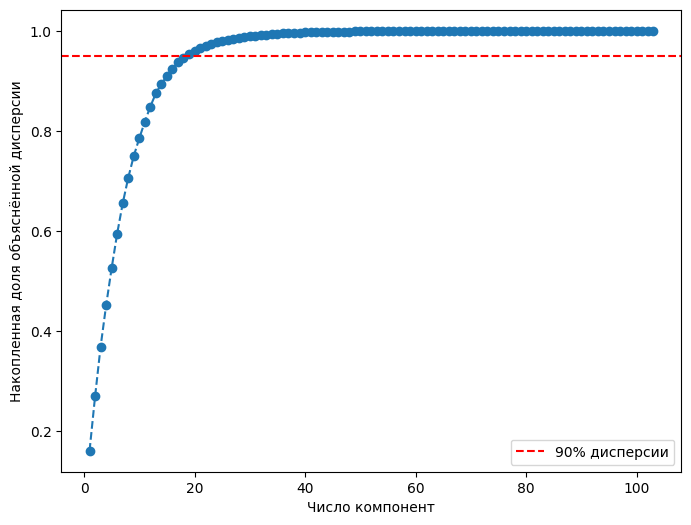

In [45]:

pca = PCA(n_components=None)
pca.fit(X_scaled)

#накопленная доля объяснённой дисперсии
explained_variance = np.cumsum(pca.explained_variance_ratio_)

#построение графика
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Число компонент')
plt.ylabel('Накопленная доля объяснённой дисперсии')
plt.axhline(y=0.95, color='r', linestyle='--', label='90% дисперсии')#так максимально сохраним информацию при минимальной сложности вычислений
plt.legend()
plt.show()

In [46]:
optimal_n_components = np.where(explained_variance >= 0.95)[0][0] + 1
print(f"Оптимальное число компонент: {optimal_n_components}")

# Создаём PCA с оптимальным числом компонент
pca = PCA(n_components=optimal_n_components)

Оптимальное число компонент: 19


In [129]:
X_pca = pca.fit_transform(X_scaled)

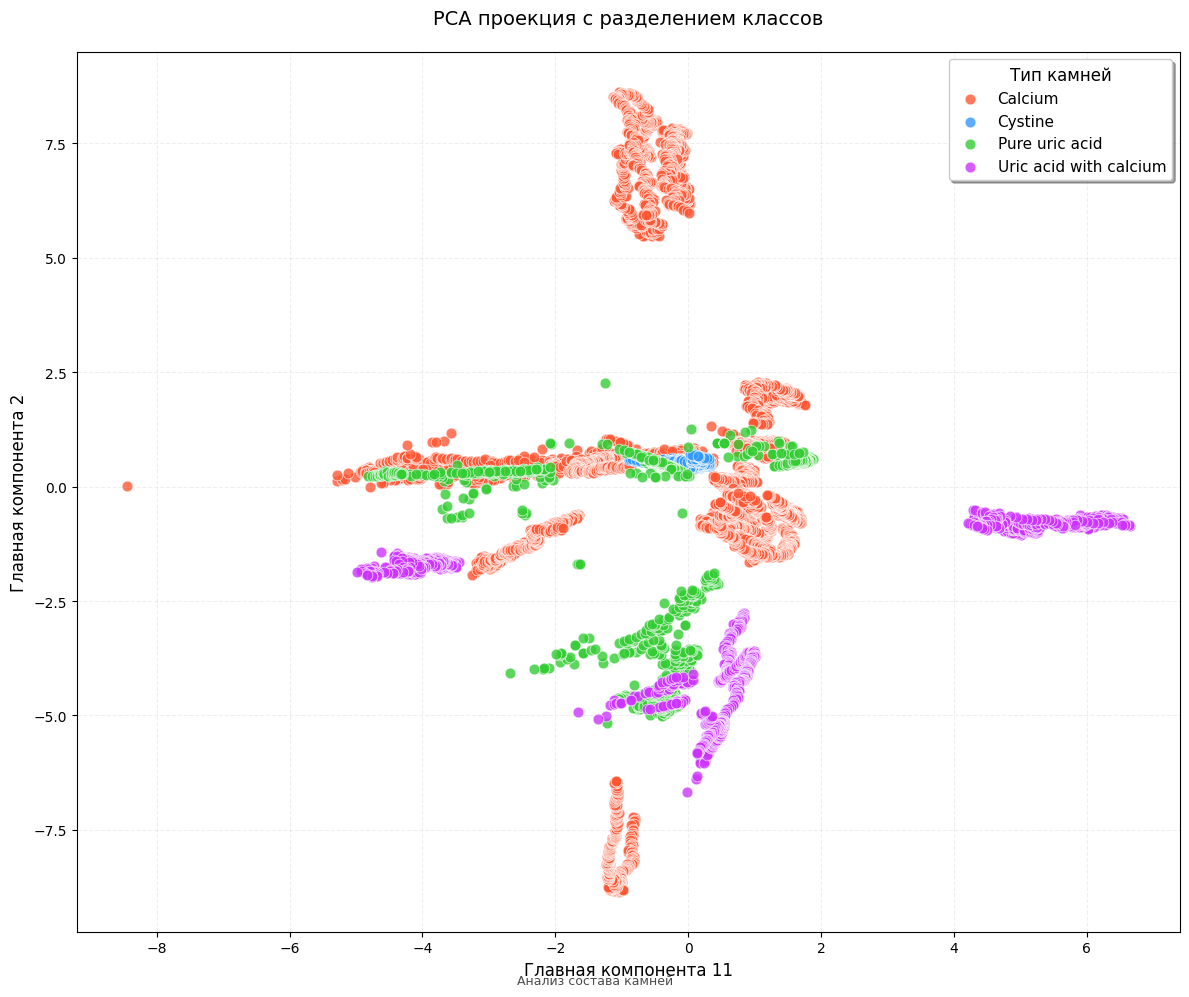

In [ ]:
plot_scatter(X_pca, y_train_encoded, le,title = "PCA проекция с разделением классов", pair=(0,1))

In [47]:
# Создание UMAP модели
umap_model = umap.UMAP(
    n_components=2,          # Для визуализации используем 2D
    n_neighbors=15,          # Меньше значений = более локальная структура
    min_dist=0.1,            # Меньше значений = плотнее кластеры
    random_state=42,
    metric='euclidean'
)

# Применение к данным
X_umap = umap_model.fit_transform(X_scaled)


In [48]:
X_scaled

array([[-0.75826114, -0.90541169,  0.50978388, ...,  0.02216734,
        -0.34640822, -0.27669615],
       [-0.75414957, -0.90798872,  0.50229904, ...,  0.03900932,
        -0.34698204, -0.27601443],
       [-0.7498259 , -0.90863298,  0.51227882, ...,  0.0448169 ,
        -0.34784277, -0.27635529],
       ...,
       [-0.0047551 ,  0.03987548,  0.34262261, ...,  0.09185829,
        -0.32130374, -0.26459567],
       [-0.01046969,  0.02111147,  0.32640547, ...,  0.0668857 ,
        -0.31771738, -0.26510696],
       [-0.01497284,  0.01064229,  0.32141558, ...,  0.05352827,
        -0.31886501, -0.26391395]], shape=(16322, 103))

In [49]:
y_train_encoded

array([0, 0, 0, ..., 0, 0, 0], shape=(16322,))

In [50]:
X_umap

array([[-8.7739725, -7.845636 ],
       [-8.770322 , -7.8490753],
       [-8.786094 , -7.7972713],
       ...,
       [-2.0083497,  3.0042403],
       [-2.0093012,  3.001764 ],
       [-2.0075064,  3.007247 ]], shape=(16322, 2), dtype=float32)

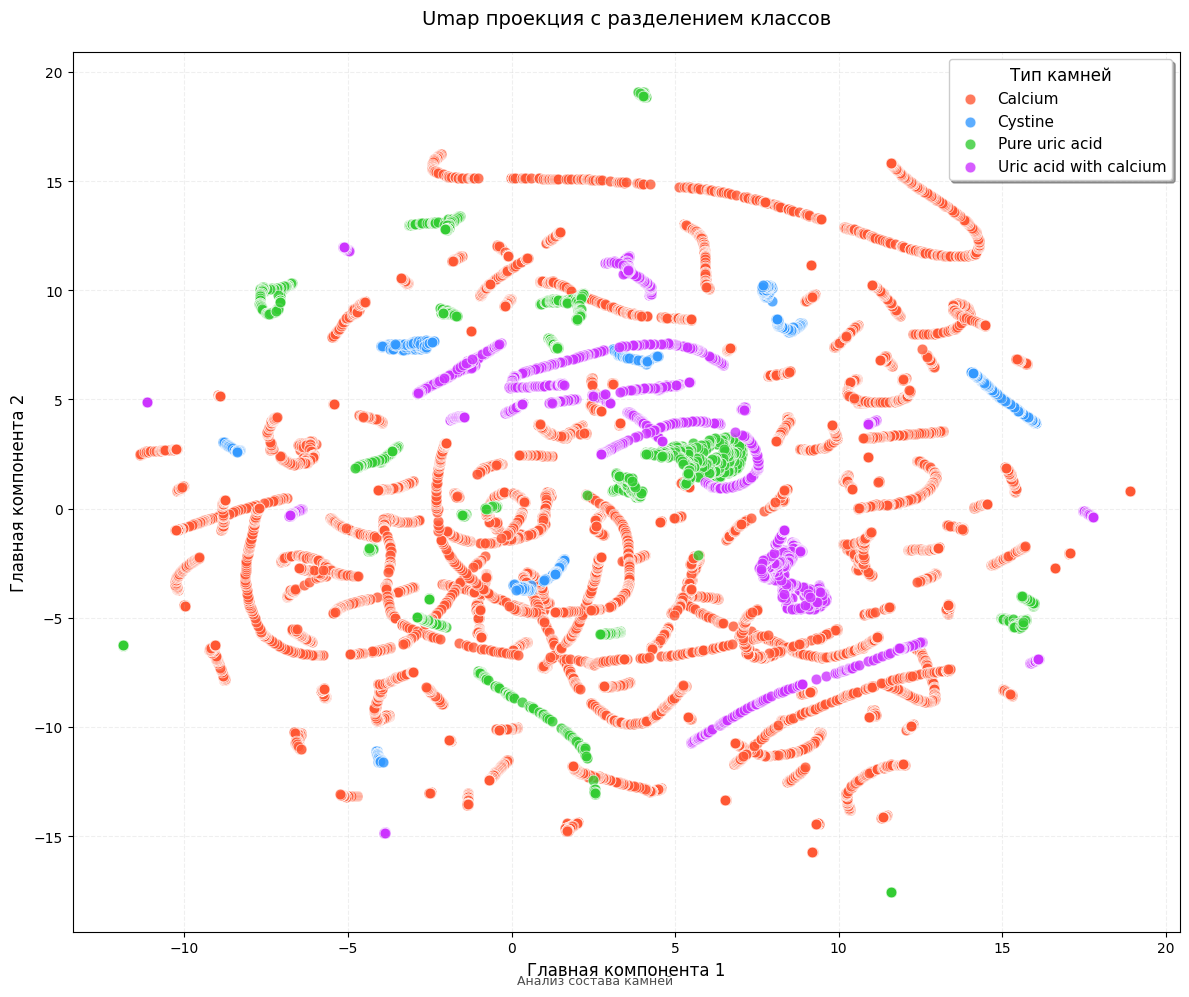

In [51]:
plot_scatter(X_umap , y_train_encoded, le,title = "Umap проекция с разделением классов", pair=(0,1))

In [52]:
from sklearn.manifold import TSNE

# Создание подвыборки для больших данных
sample_size = min(3000, X_scaled.shape[0])
np.random.seed(42)
sample_idx = np.random.choice(X_scaled.shape[0], sample_size, replace=False)
X_sample = X_scaled[sample_idx]
y_sample = y_train_encoded[sample_idx]

# Создание t-SNE модели
tsne = TSNE(
    n_components=2,
    perplexity=30,
    n_iter=1000,
    random_state=42,
    init='pca',
    learning_rate=200
)

# Применение к данным
X_tsne = tsne.fit_transform(X_sample)



/home/wsl/miniconda3/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


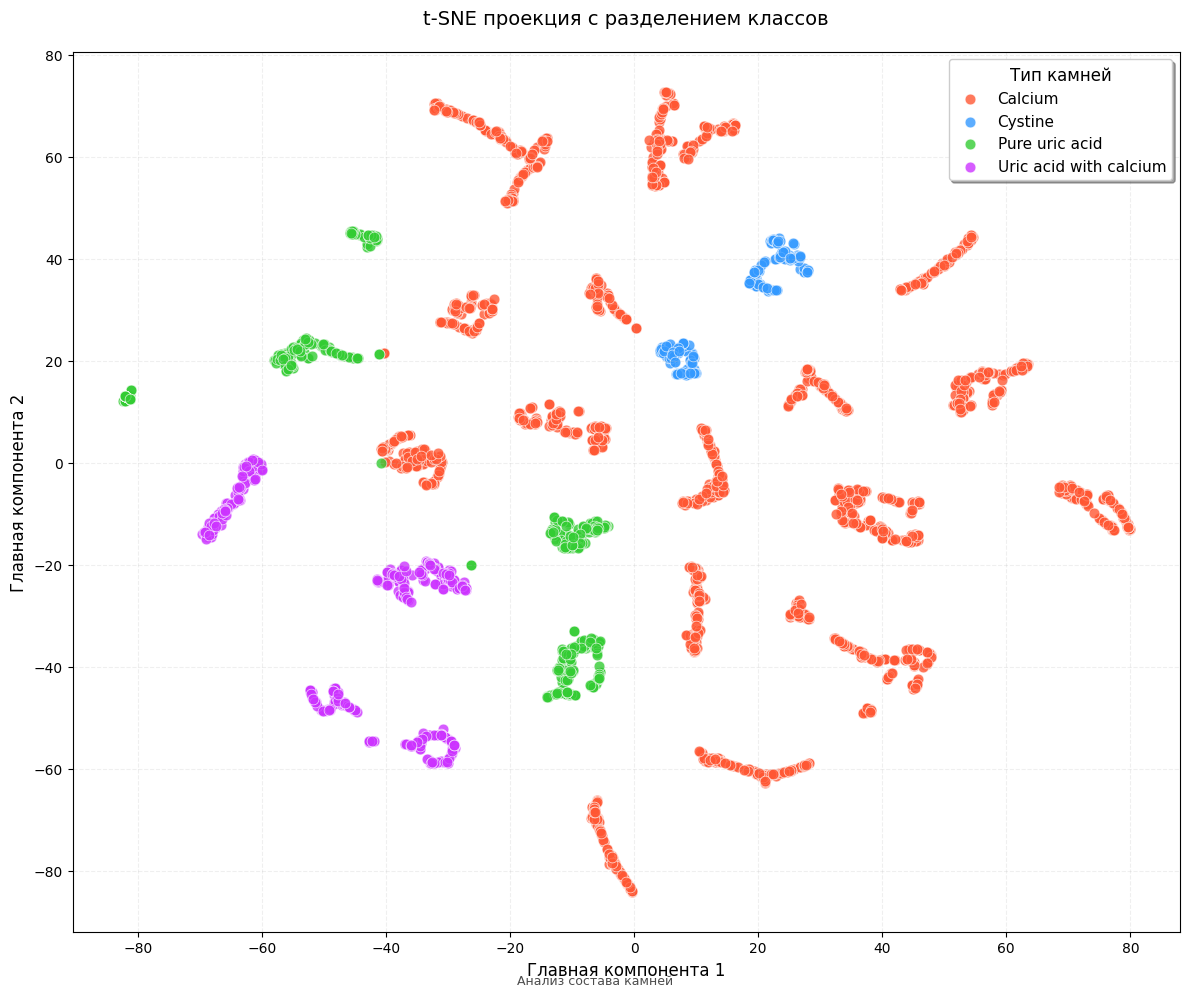

In [53]:
plot_scatter(X_tsne, y_sample, le, title="t-SNE проекция с разделением классов",pair=(0,1))

In [54]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Определение числа компонент
n_components = min(len(le.classes_) - 1, X_scaled.shape[1])
lda = LinearDiscriminantAnalysis(n_components=n_components)
X_lda = lda.fit_transform(X_scaled, y_train_encoded)


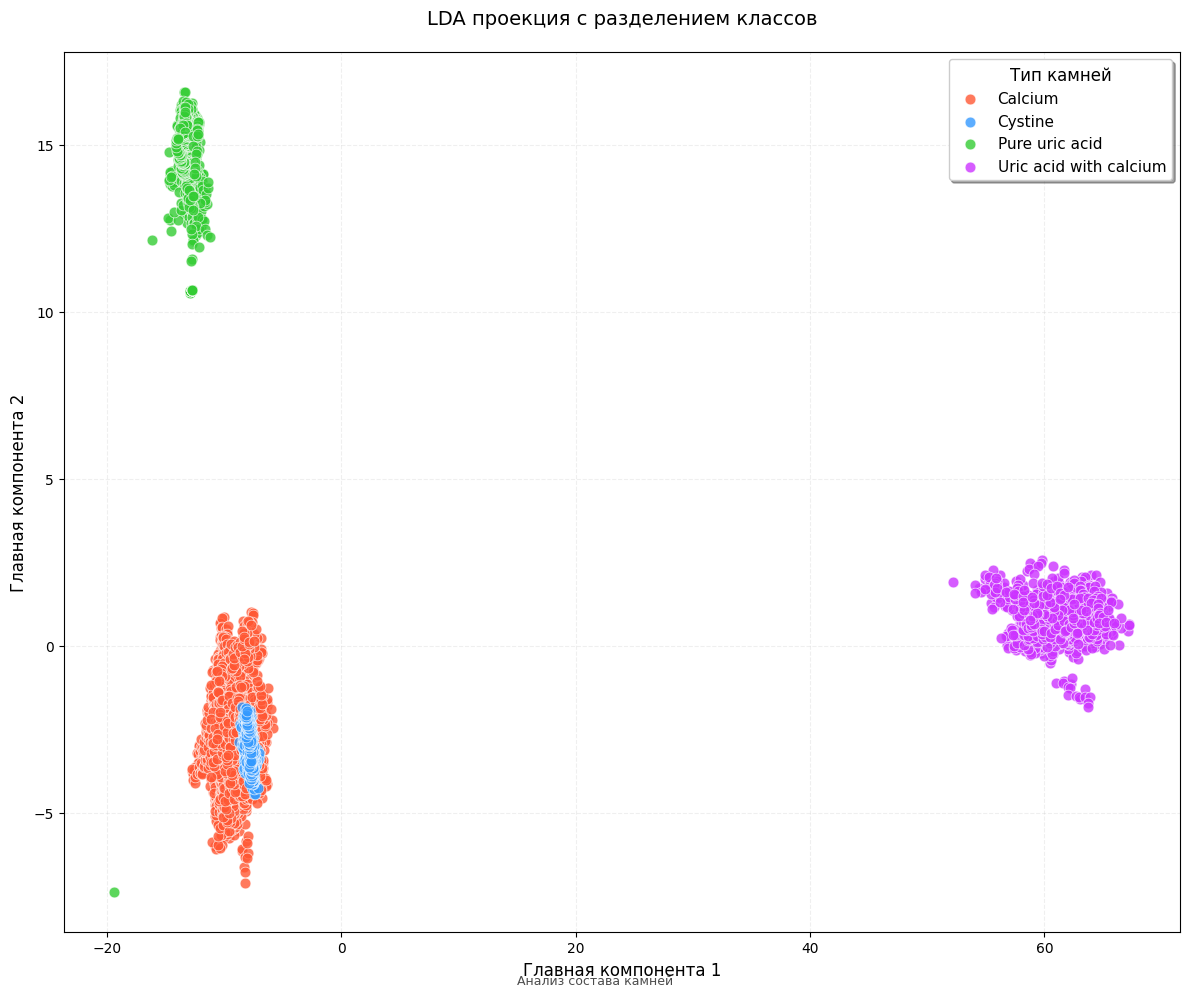

In [55]:
plot_scatter(X_lda, y_train_encoded, le, title="LDA проекция с разделением классов", pair=(0,1))

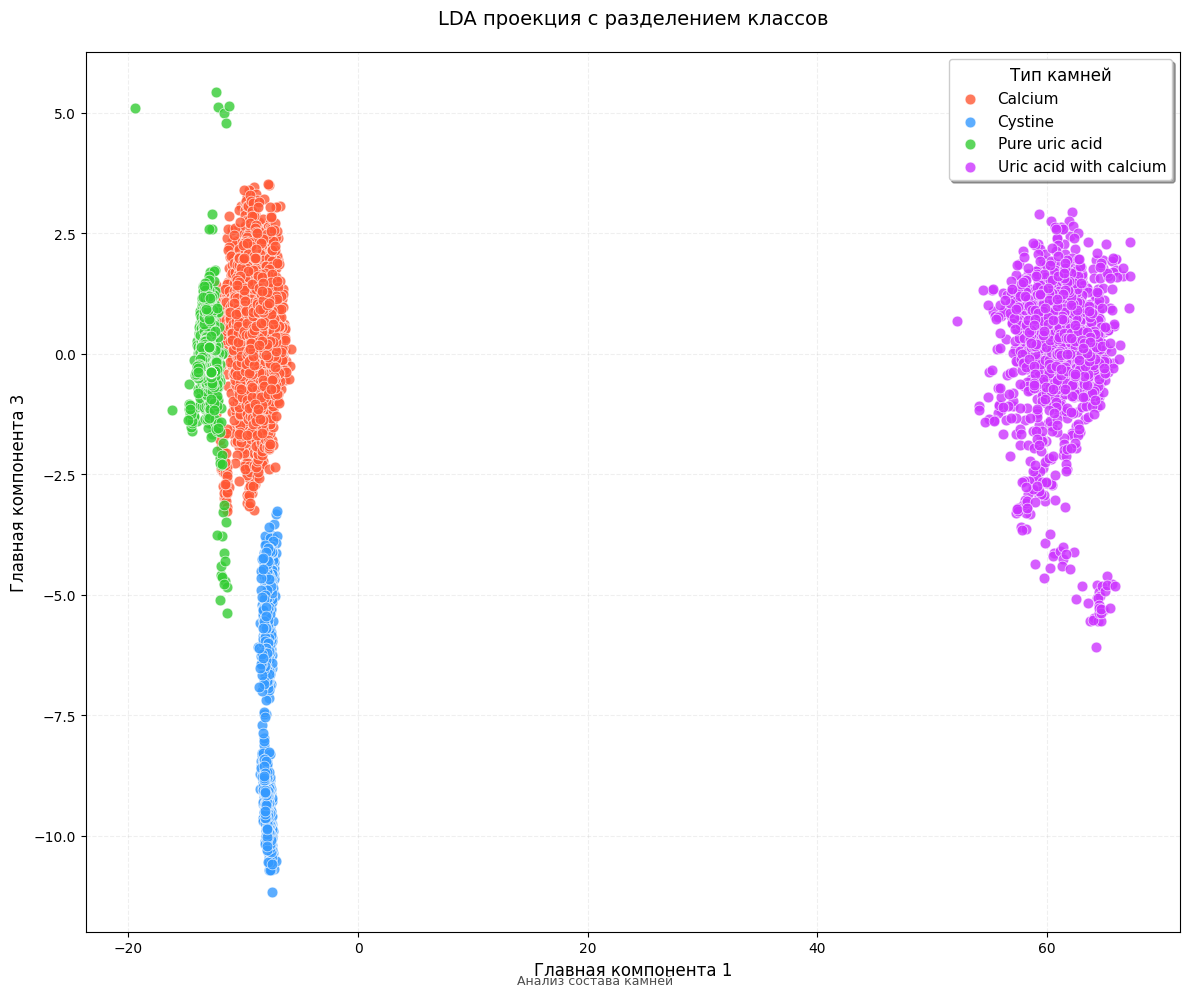

In [56]:
plot_scatter(X_lda, y_train_encoded, le, title="LDA проекция с разделением классов",pair=(0,2))

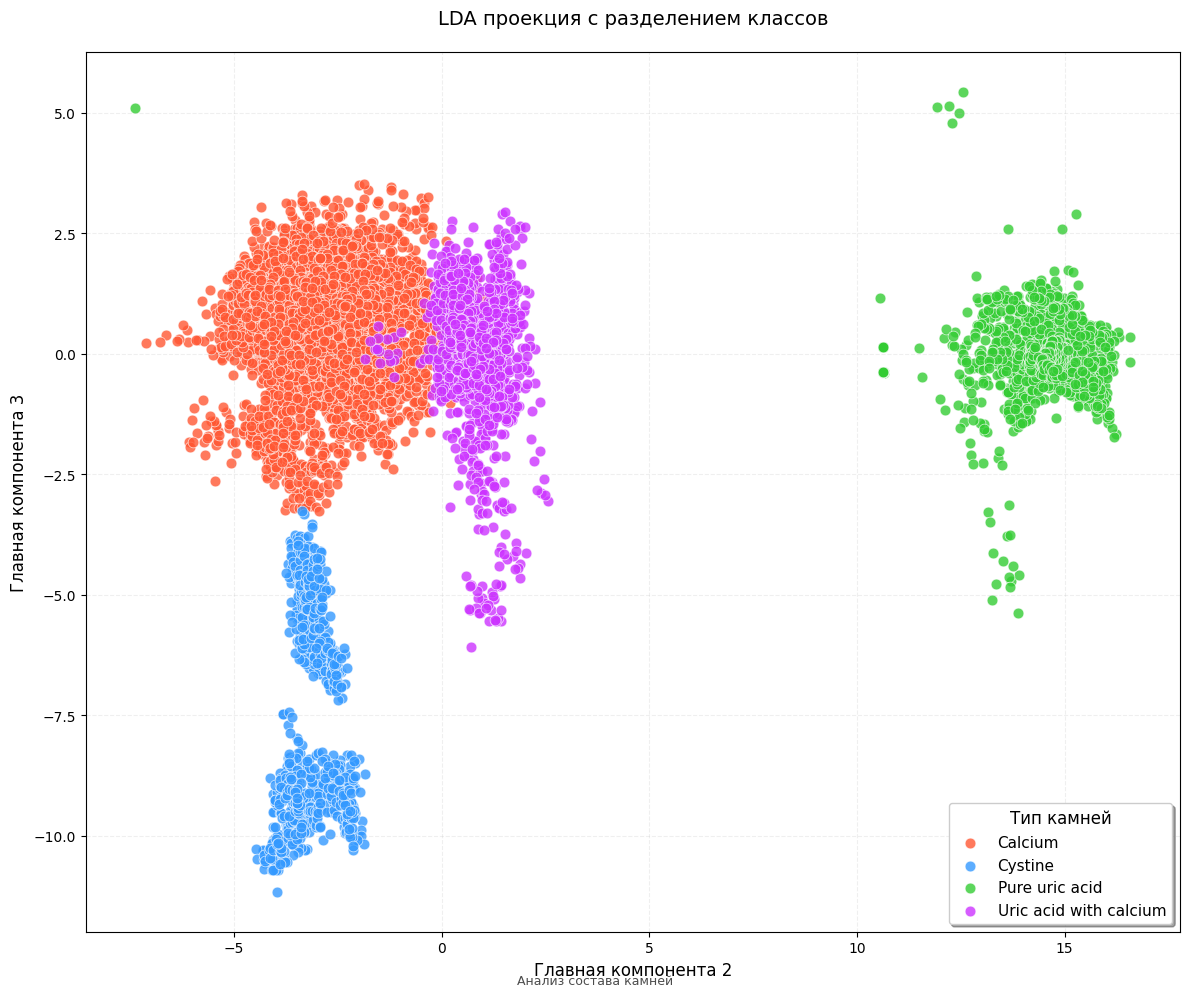

In [57]:
plot_scatter(X_lda, y_train_encoded, le, title="LDA проекция с разделением классов",pair=(1,2))

In [58]:
from sklearn.manifold import Isomap

# Создание Isomap модели
isomap = Isomap(
    n_components=2,
    n_neighbors=15,
    eigen_solver='dense'
)

# Применение к данным
X_isomap = isomap.fit_transform(X_scaled)



/home/wsl/miniconda3/lib/python3.13/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/wsl/miniconda3/lib/python3.13/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/wsl/miniconda3/lib/python3.13/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/wsl/miniconda3/lib/python3.13/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/wsl/miniconda3/lib/python3.13/site-package

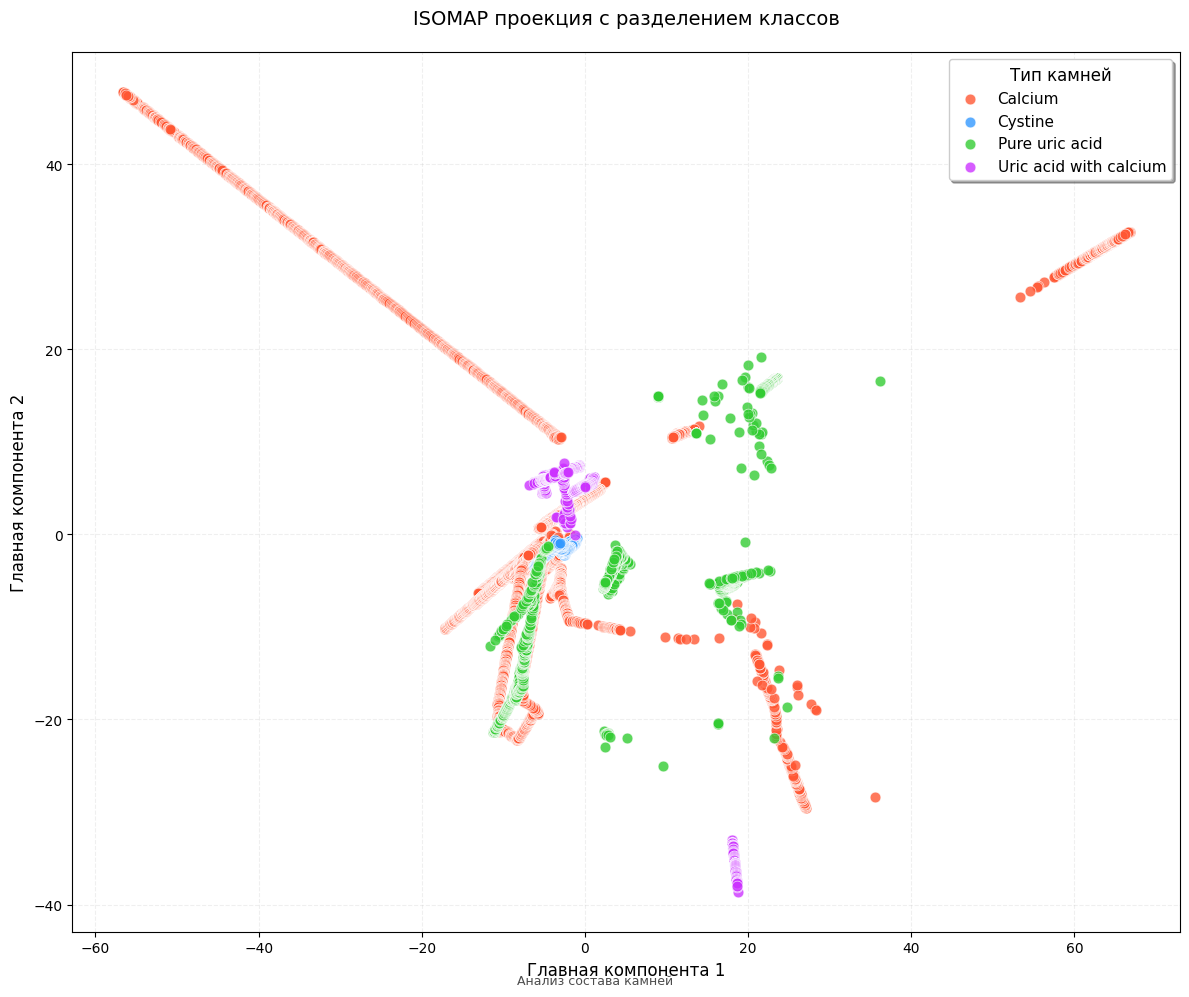

In [59]:
plot_scatter(X_isomap, y_train_encoded, le, title="ISOMAP проекция с разделением классов",pair=(0,1))

In [60]:
X_test = test_data.drop(columns = [ "Rock ID","type"], axis=1)
y_test = test_data['type']

In [61]:
X_test_scaled = scaler.transform(X_test)  # Масштабирование

In [62]:
X_test_lda = lda.transform(X_test_scaled)
X_test_lda

array([[-14.26436252, -13.83337972,  36.54245835],
       [-14.0915707 , -14.29001355,  36.76080496],
       [-14.36601962, -14.29353594,  36.95769357],
       ...,
       [-29.74075942,  -0.33798222,  13.14712518],
       [-29.57572429,  -0.48397348,  13.75741083],
       [-29.92651729,  -0.28397603,  13.12158043]], shape=(4903, 3))

In [139]:
X_test_pca = pca.transform(X_test_scaled)
X_test_pca

array([[-0.23768057,  0.14617527, -5.22391491, ...,  3.2893466 ,
         6.80909987, -0.02813041],
       [-0.1870528 ,  0.13753728, -5.24018138, ...,  3.30028788,
         6.81898056, -0.01289606],
       [-0.18756679,  0.15652837, -5.28063463, ...,  3.335887  ,
         6.91862402, -0.03103331],
       ...,
       [ 0.42808445, -0.24834567, -6.67073968, ...,  5.58746559,
         5.74747944,  1.0706137 ],
       [ 0.40908314, -0.2572786 , -6.67531365, ...,  5.61370611,
         5.82127284,  1.05964173],
       [ 0.3512226 , -0.31710227, -6.6411989 , ...,  5.72448941,
         5.7531682 ,  1.04363355]], shape=(4903, 19))

In [140]:
X_test_tsne = tsne.transform(X_test_scaled)
X_test_tsne

AttributeError: 'TSNE' object has no attribute 'transform'

In [63]:
set(y_test)

{'Calcium', 'Cystine', 'Pure uric acid', 'Uric acid with calcium'}

In [64]:
y_test_encoded = le.transform(y_test)
y_test

8061     Cystine
8062     Cystine
8063     Cystine
8064     Cystine
8065     Cystine
          ...   
38442    Calcium
38443    Calcium
38444    Calcium
38445    Calcium
38446    Calcium
Name: type, Length: 4903, dtype: object

In [65]:
X_train = X_lda
y_train = y_train_encoded

In [66]:
dddd
#X_train, X_val, y_train, y_val = train_test_split(X_lda, y_train_encoded, test_size=0.2, random_state=42)

NameError: name 'dddd' is not defined

In [67]:
le.classes_.__len__()

4

In [68]:

import numpy as np
import pandas as pd
import inspect
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    classification_report, f1_score, balanced_accuracy_score, accuracy_score,
    confusion_matrix
)
from sklearn.metrics import make_scorer
from sklearn.utils.class_weight import compute_sample_weight

# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
HAS_XGB = False
from xgboost import XGBClassifier
HAS_XGB = True


# Быстрая проверка форм
print("X_train:", np.shape(X_train), "y_train:", np.shape(y_train))
#print("X_val:",   np.shape(X_val),   "y_val:",   np.shape(y_val))
print("X_test:",  np.shape(X_test_lda), "y_test:", np.shape(y_test_encoded))

X_train: (16322, 3) y_train: (16322,)
X_test: (4903, 3) y_test: (4903,)


In [69]:
class_names = list(le.classes_)
print("Class names:", class_names)

Class names: ['Calcium', 'Cystine', 'Pure uric acid', 'Uric acid with calcium']


In [209]:
# Стратифицированный K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "f1_macro": make_scorer(f1_score, average="macro"),
    "balanced_acc": make_scorer(balanced_accuracy_score),
    "accuracy": "accuracy",
}
refit_metric = "f1_macro"

In [211]:
candidates = []

#Логистическая регрессия
candidates.append((
    "LogReg",
    LogisticRegression(max_iter=5000, random_state=42, n_jobs=None),
    {
        "C": [0.01, 0.1, 1, 3, 10],
        "solver": ["lbfgs", "saga"],
        "class_weight": [None, "balanced"],
        "penalty": ["l2"],
    }
))

#SVC
candidates.append((
    "SVC",
    SVC(random_state=42, probability=True),
    {
        "C": [0.1, 1, 3, 10],
        "kernel": ["rbf", "linear"],
        "gamma": ["scale", "auto"],
        "class_weight": [None, "balanced"],
    }
))

#RandomForest
candidates.append((
    "RF",
    RandomForestClassifier(random_state=42, n_jobs=-1),
    {
        "n_estimators": [200, 500],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt", None],
        "class_weight": [None, "balanced", "balanced_subsample"],
    }
))

#GradientBoosting (без class_weight; будем компенсировать sample_weight)
candidates.append((
    "GB",
    GradientBoostingClassifier(random_state=42),
    {
        "n_estimators": [200, 500],
        "learning_rate": [0.03, 0.1],
        "max_depth": [2, 3],
        "subsample": [0.7, 1.0],
        "max_features": [None, "sqrt"],
    }
))

#KNN (sample_weight не поддерживает) — может проигрывать при сильном дисбалансе
candidates.append((
    "KNN",
    KNeighborsClassifier(),
    {
        "n_neighbors": [3, 5, 11, 21],
        "weights": ["uniform", "distance"],
        "metric": ["minkowski"],   # p=2 по умолчанию
        "p": [1, 2],               # манхэттен/евклид
    }
))

# XGBoost 
candidates.append((
    "XGB",
    XGBClassifier(
        n_estimators=600,
        eval_metric="logloss",
        tree_method="hist",
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False
    ),
    {
        "max_depth": [3, 5, 7],
        "learning_rate": [0.03, 0.1],
        "subsample": [0.7, 1.0],
        "colsample_bytree": [0.7, 1.0],
        "min_child_weight": [1, 5],
    }
))


In [212]:
def estimator_accepts_param(estimator, param: str) -> bool:
    """Проверяем, есть ли в fit(...) параметр param (например, sample_weight)."""
    try:
        sig = inspect.signature(estimator.fit)
        return param in sig.parameters
    except (TypeError, ValueError):
        return False

def fit_with_optional_sample_weight(clf, X, y, sample_weight=None):
    """Аккуратно передаём sample_weight, только если модель это поддерживает."""
    if sample_weight is not None and estimator_accepts_param(clf, "sample_weight"):
        return clf.fit(X, y, sample_weight=sample_weight)
    else:
        return clf.fit(X, y)

In [213]:
def evaluate_model(name, model, X_test, y_test, class_names):


    print(f"\n===== [{name}] Test =====")
    y_pred_test = model.predict(X_test)
    print(classification_report(y_test, y_pred_test, target_names=class_names, digits=4))
    print("Confusion matrix (test):\n", confusion_matrix(y_test, y_pred_test))


In [214]:
results_rows = []
best_overall = {
    "name": None,
    "grid": None,
    "best_estimator": None,
    "best_score": -np.inf,
    "best_params": None
}

In [215]:
# веса классов на трейне (учитывают дисбаланс train-дистрибуции)
sample_weight_train = compute_sample_weight(class_weight="balanced", y=y_train)

In [216]:
y_train

array([0, 0, 0, ..., 0, 0, 0], shape=(16322,))

In [217]:
X_train

array([[-12.1655891 ,  -2.97137791,   0.96556837],
       [-12.16658956,  -2.9958044 ,   1.16087445],
       [-12.35977371,  -3.23137984,   1.42028907],
       ...,
       [ -7.93509022,   0.11895864,   1.01050481],
       [ -7.44527372,   0.12250732,   0.62446993],
       [ -7.76508459,   0.62511874,   1.05659501]], shape=(16322, 3))

In [218]:
for name, est, param_grid in candidates:
    #грид серч с к-фолд
    print(f"\n\n### GridSearch for: {name}")
    grid = GridSearchCV(
        estimator=est,
        param_grid=param_grid,
        scoring=scoring,
        refit=refit_metric,
        cv=skf,
        n_jobs=-1,
        verbose=1,
        return_train_score=False
    )

    # Передаём sample_weight только если модель это поддерживает
    fit_params = {}
    if estimator_accepts_param(est, "sample_weight"):
        fit_params["sample_weight"] = sample_weight_train

    grid.fit(X_train, y_train, **fit_params)

    # Сохраняем сводку
    best_score = grid.best_score_
    best_params = grid.best_params_
    print(f"Best {refit_metric} for {name}: {best_score:.4f}")
    print("Best params:", best_params)

    results_rows.append({
        "model": name,
        "best_f1_macro": best_score,
        "best_params": best_params
    })

    # Обновляем лучшую среди всех
    if best_score > best_overall["best_score"]:
        best_overall.update({
            "name": name,
            "grid": grid,
            "best_estimator": grid.best_estimator_,
            "best_score": best_score,
            "best_params": best_params
        })




### GridSearch for: LogReg
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best f1_macro for LogReg: 0.9998
Best params: {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}


### GridSearch for: SVC
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best f1_macro for SVC: 0.9999
Best params: {'C': 0.1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}


### GridSearch for: RF
Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best f1_macro for RF: 0.9998
Best params: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


### GridSearch for: GB
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best f1_macro for GB: 0.9998
Best params: {'learning_rate': 0.03, 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 200, 'subsample': 0.7}


### GridSearch for: KNN
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best f1_mac

/home/wsl/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:09:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/wsl/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:09:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/wsl/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:09:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/wsl/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:09:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/wsl/miniconda3/lib/python3.13/site-packages/xgboost/tr

Best f1_macro for XGB: 0.9999
Best params: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7}


In [230]:
pd.DataFrame(results_rows)

model  best_f1_macro                                        best_params
0  LogReg       0.999800  {'C': 1, 'class_weight': None, 'penalty': 'l2'...
1     SVC       0.999934  {'C': 0.1, 'class_weight': None, 'gamma': 'sca...
2      RF       0.999799  {'class_weight': None, 'max_depth': None, 'max...
3      GB       0.999799  {'learning_rate': 0.03, 'max_depth': 2, 'max_f...
4     KNN       0.999934  {'metric': 'minkowski', 'n_neighbors': 3, 'p':...
5     XGB       0.999934  {'colsample_bytree': 0.7, 'learning_rate': 0.0...

In [231]:
# Табличка с лучшими скорами по моделям
results_df = pd.DataFrame(results_rows).sort_values(by="best_f1_macro", ascending=False)
print("\n======= Best CV results (by f1_macro) =======")
print(results_df.to_string(index=False))

print("\n*** Overall best model:", best_overall["name"])
print("CV best f1_macro:", f"{best_overall['best_score']:.4f}")
print("Params:", best_overall["best_params"])


======= Best CV results (by f1_macro) =======
 model  best_f1_macro                                                                                                                           best_params
   SVC       0.999934                                                                {'C': 0.1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}
   XGB       0.999934                             {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7}
   KNN       0.999934                                                               {'metric': 'minkowski', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
LogReg       0.999800                                                                    {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
    GB       0.999799                                {'learning_rate': 0.03, 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 200, 'subsample': 0.7}
    RF       0.99

In [233]:
best_overall

{'name': 'SVC',
 'grid': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=SVC(probability=True, random_state=42), n_jobs=-1,
              param_grid={'C': [0.1, 1, 3, 10],
                          'class_weight': [None, 'balanced'],
                          'gamma': ['scale', 'auto'],
                          'kernel': ['rbf', 'linear']},
              refit='f1_macro',
              scoring={'accuracy': 'accuracy',
                       'balanced_acc': make_scorer(balanced_accuracy_score, response_method='predict'),
                       'f1_macro': make_scorer(f1_score, response_method='predict', average=macro)},
              verbose=1),
 'best_estimator': SVC(C=0.1, kernel='linear', probability=True, random_state=42),
 'best_score': np.float64(0.9999338653643646),
 'best_params': {'C': 0.1,
  'class_weight': None,
  'gamma': 'scale',
  'kernel': 'linear'}}

In [ ]:
# Выбираем лучшую модель из best_overall
best_model = best_overall["best_estimator"]
model = best_model
# Оценка на тестовых данных
y_pred = best_model.predict(X_test_lda)
test_f1 = f1_score(y_test_encoded, y_pred, average="macro")

print(f"Лучшая модель: {best_overall['name']}")
print(f"Параметры: {best_overall['best_params']}")
print(f"F1-macro (кросс-валидация): {best_overall['best_score']:.4f}")
print(f"F1-macro (тест): {test_f1:.4f}")

# детальный отчёт
print(classification_report(y_test_encoded, y_pred))

# сохраняем модель
import joblib
joblib.dump(best_model, "best_model.pkl")

Лучшая модель: SVC
Параметры: {'C': 0.1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}
F1-macro (кросс-валидация): 0.9999
F1-macro (тест): 0.6351
              precision    recall  f1-score   support

           0       0.40      0.46      0.42      1518
           1       0.86      0.50      0.63       812
           2       0.47      0.50      0.48      1530
           3       1.00      1.00      1.00      1043

    accuracy                           0.59      4903
   macro avg       0.68      0.61      0.64      4903
weighted avg       0.62      0.59      0.60      4903



['best_model.pkl']

In [236]:
test_df = pd.DataFrame(X_test_lda)
test_df["y"] = y_test_encoded
test_df["y_pred"] = y_pred
test_df

0          1          2  y  y_pred
0    -14.264363 -13.833380  36.542458  1       2
1    -14.091571 -14.290014  36.760805  1       2
2    -14.366020 -14.293536  36.957694  1       2
3    -14.221653 -14.252630  36.784610  1       2
4    -14.236960 -14.209658  36.808121  1       2
...         ...        ...        ... ..     ...
4898 -29.191011  -0.554677  13.068220  0       2
4899 -29.720138  -0.401530  13.364370  0       2
4900 -29.740759  -0.337982  13.147125  0       2
4901 -29.575724  -0.483973  13.757411  0       2
4902 -29.926517  -0.283976  13.121580  0       2

[4903 rows x 5 columns]

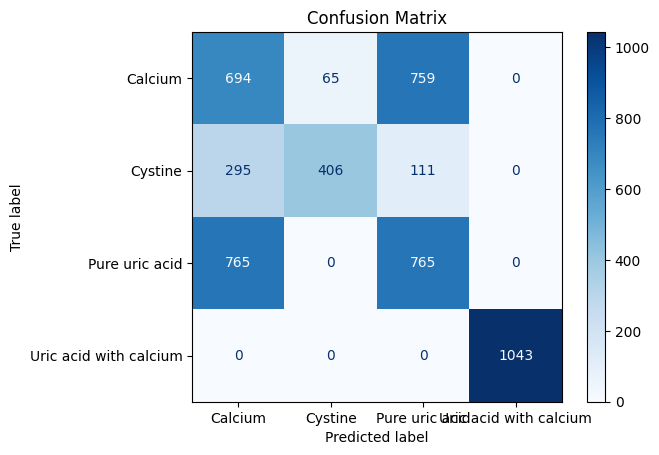

In [237]:
cm = confusion_matrix(test_df['y'], test_df["y_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=list(le.classes_))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

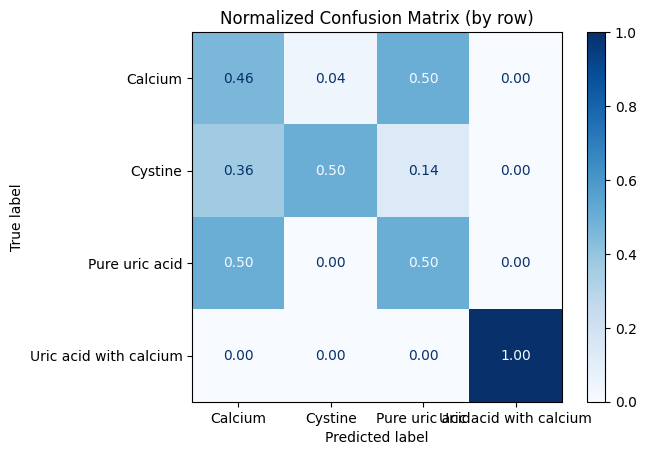

Normalized CM (row-wise):
[[0.457 0.043 0.5   0.   ]
 [0.363 0.5   0.137 0.   ]
 [0.5   0.    0.5   0.   ]
 [0.    0.    0.    1.   ]]


In [238]:
# Нормируем матрицу по строкам (верные метки)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Создаем визуализацию с частотами
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_normalized,
    display_labels=list(le.classes_)
)

# Настраиваем формат отображения (два знака после запятой)
disp.plot(cmap='Blues', values_format='.2f')  # Используйте '.1%' для процентов

plt.title('Normalized Confusion Matrix (by row)')
plt.show()

# Выводим числовое представление матрицы (опционально)
print("Normalized CM (row-wise):")
print(np.round(cm_normalized, 3))

In [239]:
from sklearn.metrics import classification_report

print(classification_report(
    test_df['y'],
    test_df['y_pred'],
    target_names=list(le.classes_)
))

                        precision    recall  f1-score   support

               Calcium       0.40      0.46      0.42      1518
               Cystine       0.86      0.50      0.63       812
        Pure uric acid       0.47      0.50      0.48      1530
Uric acid with calcium       1.00      1.00      1.00      1043

              accuracy                           0.59      4903
             macro avg       0.68      0.61      0.64      4903
          weighted avg       0.62      0.59      0.60      4903



In [240]:
test_df

0          1          2  y  y_pred
0    -14.264363 -13.833380  36.542458  1       2
1    -14.091571 -14.290014  36.760805  1       2
2    -14.366020 -14.293536  36.957694  1       2
3    -14.221653 -14.252630  36.784610  1       2
4    -14.236960 -14.209658  36.808121  1       2
...         ...        ...        ... ..     ...
4898 -29.191011  -0.554677  13.068220  0       2
4899 -29.720138  -0.401530  13.364370  0       2
4900 -29.740759  -0.337982  13.147125  0       2
4901 -29.575724  -0.483973  13.757411  0       2
4902 -29.926517  -0.283976  13.121580  0       2

[4903 rows x 5 columns]

In [241]:
probs = model.predict_proba(X_test_lda)

In [242]:
try:
    probs = model.predict_proba(X_test_lda)
except:
    probs = False
#probs

In [244]:

probs_df = pd.DataFrame(probs)
probs_df

0             1         2         3
0     7.893370e-02  2.546664e-05  0.920842  0.000198
1     1.273639e-01  1.222801e-04  0.872308  0.000206
2     8.227855e-02  2.918564e-05  0.917496  0.000196
3     1.033613e-01  6.245371e-05  0.896375  0.000201
4     9.758951e-02  5.165865e-05  0.902159  0.000200
...            ...           ...       ...       ...
4898  5.471625e-10  2.938483e-10  0.999992  0.000008
4899  4.337481e-10  2.329401e-10  0.999993  0.000007
4900  4.299086e-10  2.308781e-10  0.999993  0.000007
4901  4.595053e-10  2.467727e-10  0.999993  0.000007
4902  3.971567e-10  2.132890e-10  0.999993  0.000007

[4903 rows x 4 columns]

In [246]:
test_df["prob_Calcium"] = probs_df[0]
test_df["prob_Cystine"] = probs_df[1]
test_df["prob_Uric acid"] = probs_df[2]
test_df["prob_Uric acid calcium"] = probs_df[3]

In [247]:
from sklearn.preprocessing import label_binarize

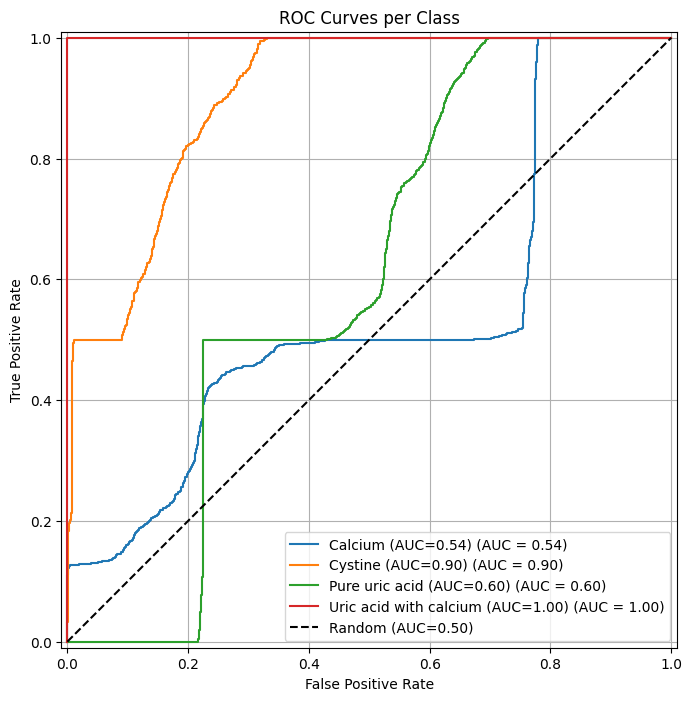

AUC Scores:
Calcium: 0.5396
Cystine: 0.9042
Pure uric acid: 0.6031
Uric acid with calcium: 1.0000


In [248]:

# Преобразуем метки в one-hot encoding
y_true = label_binarize(test_df['y'], classes=[0,1,2,3])
y_score = test_df[['prob_Calcium', "prob_Cystine",
                   'prob_Uric acid', 'prob_Uric acid calcium']].values

fig, ax = plt.subplots(figsize=(10, 8))

# Создадим словарь для хранения AUC значений
auc_scores = {}

for i, cls in enumerate(le.classes_):
    # Вычисляем ROC кривую и AUC
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    auc_scores[cls] = roc_auc
    
    # Строим кривую с подписью (включая AUC)
    RocCurveDisplay(
        fpr=fpr,
        tpr=tpr,
        roc_auc=roc_auc,
        estimator_name=f"{cls} (AUC={roc_auc:.2f})"
    ).plot(ax=ax)

# Добавляем диагональ (random classifier)
ax.plot([0, 1], [0, 1], 'k--', label="Random (AUC=0.50)")

ax.set_title("ROC Curves per Class")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc='lower right')  # Лучшее расположение для ROC
ax.grid()
plt.show()

# Дополнительно: выведем AUC значения
print("AUC Scores:")
for cls, score in auc_scores.items():
    print(f"{cls}: {score:.4f}")